# ML models with SHAP importance analysis from XGB

In this notebook, we first train the data set by XGBoost and apply the SHAP importance feature selection. Here, we only keep the 50 features that have the highest SHAP importance here. These features will be used in Linear Regression, SVR, and NN. We only focus on the efficacy for Docetaxel. The results will be compared with the previous results with variance-based feature selection

In [ ]:
# Install SHAP and XG Boost packages to local kernel

%pip install shap
%pip install xgboost

In [45]:
# import necessary packages

# Plot the figures inline, necessary only for Jupyter notebook
%matplotlib inline 

import os # miscelleaneous operating system interface
import numpy as np  # import numpy
import pandas as pd # import pandas
import matplotlib.pyplot as plt 
import seaborn as sns # import seaborn for data visualization

from sklearn.model_selection import train_test_split # splitting data into training and testing set
from sklearn.model_selection import GridSearchCV # for hyperparameter tuning
from sklearn.pipeline import Pipeline # may need it later for feature engineering

from sklearn.linear_model import LinearRegression 
from sklearn.svm import SVR

from sklearn.metrics import root_mean_squared_error as RMSE # calculate RMSE

import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import Dense
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

import shap
import xgboost as xgb

In [46]:
# import the data set for drugs and tumors

df_drug=pd.read_csv('GDSC2_label_14drugs.csv') 
df_drug.set_index('Unnamed: 0', inplace=True)

# We only focus on the 3 drugs with largest variances in their efficacies among different drugs
df_drug.std().sort_values(ascending = False).iloc[0:3]

# import the data set for tumor cells (cell lines) and genes

df_tumor=pd.read_csv('GDSC2_expression14.csv') # load the data set for tumors and cell lines
df_tumor.set_index('Unnamed: 0', inplace=True)

gene=list(df_tumor.columns)

print('Shape of data frame for tumors:', df_tumor.shape) # shape for tumor data

# Expected result: 805 tumor cells (instances) and 17419 genes (features)

# Data merging between the 3 drugs with the largest variances and the tumors data
# See the EDA notebook

drug1='Docetaxel'
drug2='Trametinib'
drug3='Entinostat'

df_1=pd.concat([df_tumor, df_drug[drug1].round(2)], axis=1) # axis=1 because we join the columns, not rows
df_2=pd.concat([df_tumor, df_drug[drug2].round(2)], axis=1) 
df_3=pd.concat([df_tumor, df_drug[drug3].round(2)], axis=1) 

print(f'Shape of data frame for {drug1}:', df_1.shape) # shape for data frame for 1 kind of drug

Shape of data frame for tumors: (805, 17419)
Shape of data frame for Docetaxel: (805, 17420)


1. XG Boost and SHAP importance analysis for Docetaxel

In [47]:
X = df_1.drop(drug1, axis=1)  # features 
y = df_1.iloc[:,-1:] # targets

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.2)

# Train model
model = xgb.XGBRegressor(objective ='reg:squarederror')
model.fit(X_train, y_train)

# Explain model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualize the importance of the features
# shap.summary_plot(shap_values, X_test, plot_type="bar")

print('SHAP calculation finished on whole data set')

SHAP calculation finished on whole data set


In [48]:
#  mean absolute SHAP values for each gene

from sklearn.metrics import root_mean_squared_error as RMSE # calculate RMSE

n=50 # Select top 50 genes

shap_sum = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['Gene', 'SHAP Importance']
importance_df = importance_df.sort_values('SHAP Importance', ascending=False)

top_genes = importance_df.head(n)  
selected_features = top_genes['Gene'].values
print(selected_features)

['SDC4' 'RPL11' 'FAM98B' 'RSL24D1' 'TBPL1' 'GNA11' 'NAV2' 'HEATR1' 'TPST2'
 'HMGN4' 'TRIP10' 'TRABD' 'ZNF526' 'SNRPA1' 'SH3BP1' 'BTAF1' 'WDR75'
 'G6PC' 'KLRG1' 'UBE2C' 'BRD3' 'BASP1' 'CHSY1' 'EP400NL' 'IRAK2' 'SLC6A5'
 'DGCR6L' 'AMTN' 'PRPS1L1' 'TP53TG5' 'LGALS8-AS1' 'TENC1' 'WDR83'
 'C15orf56' 'RFESD' 'C3orf79' 'CDT1' 'SLC25A17' 'HAUS6' 'OR7A17' 'MYO1B'
 'ZCCHC12' 'PPP2R2B' 'STX5' 'FHDC1' 'TRPV2' 'ZKSCAN4' 'SLC8A1' 'MTMR6'
 'RAB5C']


2. XGB on the 50 most important features with hyperparameters tuning

In [49]:
from sklearn.model_selection import GridSearchCV

# hyperparameters set
params = {
    'max_depth': [2, 3, 4],
    'min_child_weight': [1, 5, 10], # minimum number of instances needed to be in each node
    'gamma': [0.001, 0.01, 0.1], # minimum loss reduction required to make a further partition
    'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5]
}

# fine-tuning using Grid Search 
# cv : number of k-fold cross validation

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective ='reg:squarederror'),
                           param_grid=params,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           verbose=1)

grid_search.fit(X_train[selected_features], y_train)
print(f'Best parameters found: {grid_search.best_params_}')

best_params = grid_search.best_params_
model = xgb.XGBRegressor(objective ='reg:squarederror', **best_params)
model.fit(X_train[selected_features], y_train)

# Prediction on training data
y_train_pred = model.predict(X_train[selected_features])
train_rmse = np.round(RMSE(y_train, y_train_pred),3)

# Prediction on test data
y_test_pred = model.predict(X_test[selected_features])
test_rmse = np.round(RMSE(y_test, y_test_pred),3)

print(f'RMSE for training set for {drug1}: {train_rmse}')
print(f'RMSE for testing set for RMSE for {drug1}: {test_rmse}')

Fitting 3 folds for each of 135 candidates, totalling 405 fits
Best parameters found: {'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 10}
RMSE for training set for Docetaxel: 0.076
RMSE for testing set for RMSE for Docetaxel: 0.158


In [50]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test[selected_features])

# Summary plot
# shap.summary_plot(shap_values, X_test[selected_features])

3. Linear regression with the 50 selected features from SHAP

In [52]:
# Using the selected genes from variance-based slection
# Simple linear regression model on Docetaxel, Trametinib, Entinostat

# 20% of the data is used as test set, meaning 161 cell lines are saved for the test set
df_train, df_test = train_test_split(df_1, shuffle=True, random_state=42, test_size=.2)

lin_reg = LinearRegression()
lin_reg.fit(df_train[selected_features], df_train.iloc[:,-1:])

# The resuls: y_0 + y_coeff dot (genes)
# y_0, y_coeff = lin_reg.intercept_, lin_reg.coef_

# Calculate the RMSE
ytrain = lin_reg.predict(df_train[selected_features])
train_lin_rmse = RMSE(df_train.iloc[:,-1:], ytrain)

ytest = lin_reg.predict(df_test[selected_features])
test_lin_rmse = RMSE(df_test.iloc[:,-1:], ytest)

print (f"RMSE for the training set for {drug1}", np.round(train_lin_rmse,3))
print (f"RMSE for the test set for {drug1}", np.round(test_lin_rmse,3))
print(f"sd in efficacy of {drug1}", df_1[drug1].std().round(3))

RMSE for the training set for Docetaxel 0.152
RMSE for the test set for Docetaxel 0.17
sd in efficacy of Docetaxel 0.192


4. SVR with the 50 selected features from SHAP

In [54]:
# 20% of the data is used as test set, meaning 161 cell lines are saved for the test set
df_train, df_test = train_test_split(df_1, shuffle=True, random_state=42, test_size=.2)

# Hyperparameters
# C: L2 Regularization parameter ~ 1/C: Reduce if overfitting
# epsilon: width of the tube
# gamma: can be included in poly, rbf
# skip linear regression here

params = {'C': [0.05, 0.1, 0.15],  
              'gamma': [0.1, 0.01, 0.001,0.0001,0.00001], 
              'epsilon': [10, 1,0.1,0.01,0.001],
              'kernel': ['rbf']}  

# cv : number of k-fold cross validation

grid_search = GridSearchCV(SVR(),
                           param_grid=params,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           verbose=1)

grid_search.fit(df_train[selected_features], df_train.iloc[:,-1:].values.ravel())
print(f'Best parameters found: {grid_search.best_params_}')

best_params = grid_search.best_params_
model = SVR(**best_params)
model.fit(df_train[selected_features], df_train.iloc[:,-1:].values.ravel())

# Prediction on training data
y_train_pred = model.predict(df_train[selected_features])
train_rmse = np.round(RMSE(df_train.iloc[:,-1:], y_train_pred),3)

# Prediction on test data
y_test_pred = model.predict(df_test[selected_features])
test_rmse = np.round(RMSE(df_test.iloc[:,-1:], y_test_pred),3)

print(f'Training RMSE for {drug1}: {train_rmse}')
print(f'Test RMSE for {drug1}: {test_rmse}')
print(f"sd in efficacy of {drug1}", df_1[drug1].std().round(3))

Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best parameters found: {'C': 0.1, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Training RMSE for Docetaxel: 0.148
Test RMSE for Docetaxel: 0.162
sd in efficacy of Docetaxel 0.192


5. NN with 2 hidden layers

Epoch 1/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - RootMeanSquaredError: 0.7170 - loss: 0.5142
Epoch 2/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - RootMeanSquaredError: 0.6886 - loss: 0.4741
Epoch 3/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - RootMeanSquaredError: 0.6796 - loss: 0.4619
Epoch 4/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step - RootMeanSquaredError: 0.6519 - loss: 0.4250
Epoch 5/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - RootMeanSquaredError: 0.6395 - loss: 0.4090
Epoch 6/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - RootMeanSquaredError: 0.6187 - loss: 0.3828
Epoch 7/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - RootMeanSquaredError: 0.6089 - loss: 0.3709
Epoch 8/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - RootMeanSquaredError: 0.5935 - loss: 0.3523
Epoch 9/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - RootMeanSquaredError: 0.5607 - loss: 0.3144
Epoch 10/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - RootMeanSquaredError: 0.5330 - loss: 0.2842
Epoch 11/

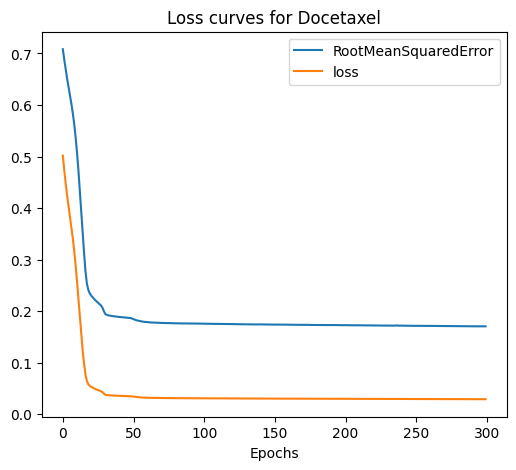

In [56]:
# 20% of the data is used as test set, meaning 161 cell lines are saved for the test set
df_train, df_test = train_test_split(df_1, shuffle=True, random_state=42, test_size=.2) # For Docetaxel

scaler = make_column_transformer((StandardScaler(), selected_features), remainder='passthrough')
scaler.fit(df_train)
scaler.transform(df_train)
scaler.transform(df_test)

# Try 2 hidden layer

model = keras.models.Sequential([
    Dense(10,activation='tanh'),
    Dense(5,activation='tanh'),
    Dense(1, activation='linear')
])

# Use Adam optimizer, learning rate 0.00001, RMSE for metrics

model.compile(loss = "mean_squared_error", optimizer = Adam(learning_rate=0.00005), metrics=['RootMeanSquaredError'])
history = model.fit(df_train[selected_features], df_train.iloc[:,-1:], epochs=300)

y_pred_test = model.predict(df_test[selected_features])

print(f"RMSE for test set for {drug1}:", np.round(RMSE(df_test.iloc[:,-1:], y_pred_test),3))

pd.DataFrame(history.history).plot(figsize=(6,5))
plt.xlabel("Epochs")
plt.title(f'Loss curves for {drug1}')
plt.legend();